<a href="https://colab.research.google.com/github/JiaSunDeepLearning/SRGAN/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/Autoencodercheckpoint/foo.txt', 'w') as f:
    f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/Autoencodercheckpoint/foo.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hello Google Drive!

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# 在Windows上运行请不要复制这一段
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
'''
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# 如果出现不能分配显存的提示，请加上这一段，顺序不变，如果没有bug，不要多此一举
'''

Epoch 0, avg_Loss: 0.10586649179458618 (mse)
Epoch 1, avg_Loss: 0.07784734666347504 (mse)
Epoch 2, avg_Loss: 0.0499848946928978 (mse)
Epoch 3, avg_Loss: 0.035652242600917816 (mse)
Epoch 4, avg_Loss: 0.02492900751531124 (mse)
Epoch 5, avg_Loss: 0.022746603935956955 (mse)
Epoch 6, avg_Loss: 0.01896159164607525 (mse)
Epoch 7, avg_Loss: 0.016878163442015648 (mse)
Epoch 8, avg_Loss: 0.015883956104516983 (mse)
Epoch 9, avg_Loss: 0.013678508810698986 (mse)
Epoch 10, avg_Loss: 0.01389006245881319 (mse)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


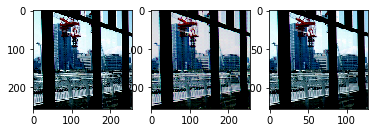

Epoch 11, avg_Loss: 0.01344948261976242 (mse)
Epoch 12, avg_Loss: 0.01252354122698307 (mse)
Epoch 13, avg_Loss: 0.012260336428880692 (mse)
Epoch 14, avg_Loss: 0.013081160373985767 (mse)
Epoch 15, avg_Loss: 0.012822603806853294 (mse)
Epoch 16, avg_Loss: 0.012052946723997593 (mse)
Epoch 17, avg_Loss: 0.01137291919440031 (mse)
Epoch 18, avg_Loss: 0.01239725761115551 (mse)
Epoch 19, avg_Loss: 0.012769147753715515 (mse)
Epoch 20, avg_Loss: 0.011840438470244408 (mse)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


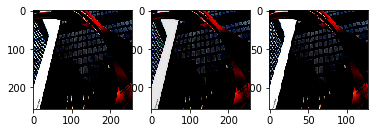

Epoch 21, avg_Loss: 0.011803110130131245 (mse)
Epoch 22, avg_Loss: 0.010793060064315796 (mse)
Epoch 23, avg_Loss: 0.011015531606972218 (mse)
Epoch 24, avg_Loss: 0.010457688011229038 (mse)


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import random

Batch_size = 25

import matplotlib.pyplot as plt


loss_object = tf.keras.losses.MeanSquaredError()
loss_object2 = tf.keras.losses.BinaryCrossentropy(from_logits=True)

g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

train_loss_g = tf.keras.metrics.Mean()
train_loss_d = tf.keras.metrics.Mean()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, [32, 32])
    # image = tf.image.rgb_to_grayscale(image)
    image = tf.image.random_crop(value=image, size=[256, 256, 3])
    image = tf.cast(image, dtype=tf.float32)

    image = image / (255.0 / 2.0)  # normalize to [-1,1] range
    image = image - 1
    return image


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


def data_load(path):
    data_root = pathlib.Path(path)
    all_image_paths = list(data_root.glob('*.*'))
    all_image_paths = [str(path) for path in all_image_paths]

    # 重新排序
    random.shuffle(all_image_paths)

    # temp = np.array(all_image_paths)
    # np.save('a.npy', temp)
    # temp = np.load('a.npy')
    # all_image_paths = temp.tolist()

    image_count = len(all_image_paths)

    # 将字符串数组切片，得到一个字符串数据集
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

    # 现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image 来动态加载和格式化图片
    image_hr_ds = path_ds.map(load_and_preprocess_image,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(Batch_size)

    return image_hr_ds, image_count


@tf.function
def train_step(train_hr, train_lr):
    with tf.GradientTape() as tape:
        prediction = net(train_lr)
        loss = loss_object(prediction, train_hr)

    gradients = tape.gradient(loss, net.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients, net.trainable_variables))
    train_loss_g(loss)
    return loss


@tf.function
def train_step2(train_hr, train_lr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        prediction = net(train_lr, training=True)

        real_output = dnet(train_hr, training=True)
        fake_output = dnet(prediction, training=True)

        # G
        g_loss = generator_loss(fake_output, train_hr, prediction)

        # D
        d_loss = discriminator_loss(real_output, fake_output)

    gradients_g = gen_tape.gradient(g_loss, net.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients_g, net.trainable_variables))

    gradients_d = disc_tape.gradient(d_loss, dnet.trainable_variables)
    d_optimizer.apply_gradients(zip(gradients_d, dnet.trainable_variables))

    train_loss_g(g_loss)
    train_loss_d(d_loss)


def discriminator_loss(real_output, fake_output):
    real_loss = loss_object2(tf.ones_like(real_output), real_output)
    fake_loss = loss_object2(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output, train_hr, prediction):
    gan_loss = loss_object2(tf.ones_like(fake_output), fake_output)
    mse = loss_object(train_hr, prediction)
    return gan_loss + mse


def train():

    for i in range(1000):
        image_hr_ds, image_count = data_load('/content/drive/My Drive/Urben100/')
        j = 1
        sum_loss = 0
        for train_hr in image_hr_ds:

            train_lr = tf.image.resize(
                train_hr,
                (128, 128),
                method=tf.image.ResizeMethod.BICUBIC,
                preserve_aspect_ratio=False,
                antialias=False,
                name=None
            )
            loss = train_step(train_hr, train_lr)
            # template = 'Epoch {}, Batch {}, Loss: {} '
            # print(template.format(i, j, loss))
            j += 1
            sum_loss += loss
        sum_loss = sum_loss / j
        template = 'Epoch {}, avg_Loss: {} (mse)'
        print(template.format(i, sum_loss))
        net.save_weights('/content/drive/My Drive/gancheckpoint/ckpt')

        if i % 10 == 0 and i != 0:
            prediction = net(tf.reshape(train_lr[0], (1, 128, 128, 3)), training=False)
            plt.figure()
            plt.subplot(1, 3, 1)
            plt.imshow(train_hr[0])

            plt.subplot(1, 3, 2)
            plt.imshow(prediction[0])

            plt.subplot(1, 3, 3)
            plt.imshow(train_lr[0])
            plt.show()

    for i in range(10):
        image_hr_ds, image_count = data_load('/content/drive/My Drive/Urben100/')
        for train_hr in image_hr_ds:
            train_lr = tf.image.resize(
                train_hr,
                (128, 128),
                method=tf.image.ResizeMethod.BICUBIC,
                preserve_aspect_ratio=False,
                antialias=False,
                name=None
            )
            train_step2(train_hr, train_lr)
        template = 'Epoch {}, G Loss: {} , D Loss : {}'
 
        print(template.format(i, train_loss_g.result(), train_loss_d.result()))


def residual_block(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters=filters, kernel_size=(size, size), strides=(1, 1), padding='SAME',
                               kernel_initializer='he_normal'))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.01))

    result.add(tf.keras.layers.ReLU())
    result.add(
        tf.keras.layers.Conv2D(filters=filters, kernel_size=(size, size), strides=(1, 1), padding='SAME',
                               kernel_initializer='he_normal'))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.01))
    result.add(tf.keras.layers.ReLU())

    return result


def Gnet():
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    block_stack = [
        residual_block(64, 3, apply_dropout=False),  # (bs, 128, 128, 64)
        residual_block(64, 3, apply_dropout=False),  # (bs, 128, 128, 64)
        residual_block(64, 3, apply_dropout=False),  # (bs, 128, 128, 64)
        residual_block(64, 3, apply_dropout=False),  # (bs, 128, 128, 64)
        residual_block(64, 3, apply_dropout=False),  # (bs, 128, 128, 64)
    ]

    block_stack2 = [
        residual_block(64, 3, apply_dropout=False),  # (bs, 128, 128, 64)
        residual_block(64, 3, apply_dropout=False),  # (bs, 128, 128, 64)
    ]

    layer1 = (tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='SAME',
                                     activation=tf.nn.leaky_relu, kernel_initializer='he_normal'))

    layer2 = (tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='SAME',
                                     activation=tf.nn.leaky_relu, kernel_initializer='he_normal'))
    layer_out = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='SAME',
                                       activation=tf.nn.tanh, kernel_initializer='he_normal')
    x = inputs
    x = layer1(x)
    n = x
    for block in block_stack:
        xx = x
        x = block(x)
        x += xx
    x += n
    x = layer2(x)
    x = tf.nn.depth_to_space(x, 2, data_format='NHWC')

    n = x
    for block in block_stack2:
        xx = x
        x = block(x)
        x += xx
    x += n

    x = layer_out(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


def Dnet():
    input = tf.keras.layers.Input(shape=[256, 256, 3])

    layer1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='valid',
                                    activation=tf.nn.leaky_relu, kernel_initializer='he_normal')

    layer2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='valid',
                                    activation=tf.nn.leaky_relu, kernel_initializer='he_normal')

    layer3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='valid',
                                    activation=tf.nn.leaky_relu, kernel_initializer='he_normal')

    layer_flatten = tf.keras.layers.Flatten()
    layer_fc = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal')
    layer_out = tf.keras.layers.Dense(1)

    x = input
    x = layer1(x)
    x = layer2(x)
    x = layer3(x)
    x = layer_flatten(x)
    x = layer_fc(x)
    p = layer_out(x)

    return tf.keras.Model(inputs=input, outputs=p)


if __name__ == '__main__':
    net = Gnet()
    dnet = Dnet()
    try:
        net.load_weights('/content/drive/My Drive/gancheckpoint/ckpt')
    except Exception:
      pass
    train()


